In [14]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import psd_array_welch
import seaborn as sns

# Single Patient Validation

In [3]:
print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1., 4.
# event_id = dict(left=2, right=3)
event_id = dict(hands=2, feet=3)
subject = [1]
# subject = 1
# runs = [4, 8, 12]  # motor imagery: left vs right hand
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = [f'../datasets/bci2000-mi/S{subj:03d}/S{subj:03d}R{run:02d}.edf' for run in runs for subj in subject]
# marker_fnames = [f'../datasets/bci2000-mi/S{subj:03d}/S{subj:03d}R{subj:02d}.vmrk' for run in runs for subj in subject]

# raw_fnames = eegbci.load_data(subject, runs, path='../datasets/')
print(raw_fnames)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)



Automatically created module for IPython interactive environment
['../datasets/bci2000-mi/S001/S001R06.edf', '../datasets/bci2000-mi/S001/S001R10.edf', '../datasets/bci2000-mi/S001/S001R14.edf']
Extracting EDF parameters from /Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/datasets/bci2000-mi/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/datasets/bci2000-mi/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-

<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

In [604]:
raw.annotations

<Annotations | 94 segments: BAD boundary (2), EDGE boundary (2), T0 (45), ...>

In [4]:
# Apply band-pass filter
raw.filter(8., 30., fir_design='firwin', skip_by_annotation='edge') # sensorimotor rhythms

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs 
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
labels = epochs.events[:, -1] - 2

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


In [588]:
epochs_data = epochs.get_data()
print(epochs_data.shape)


(45, 64, 801)


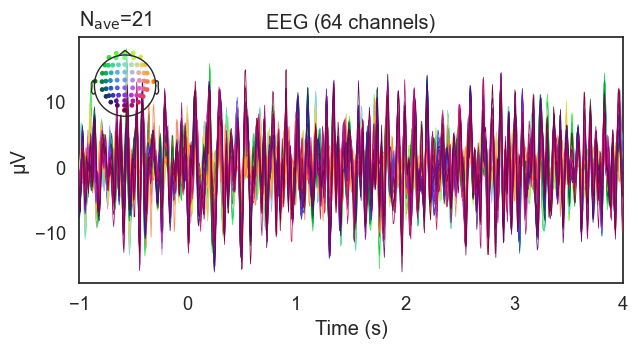

In [606]:
epochs['hands'].average().plot();

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/Users/anushmutyala/opt/miniconda3/envs/torch/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


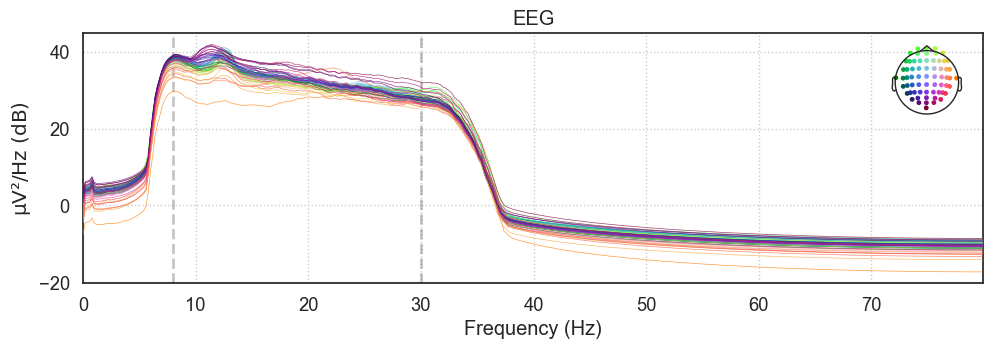

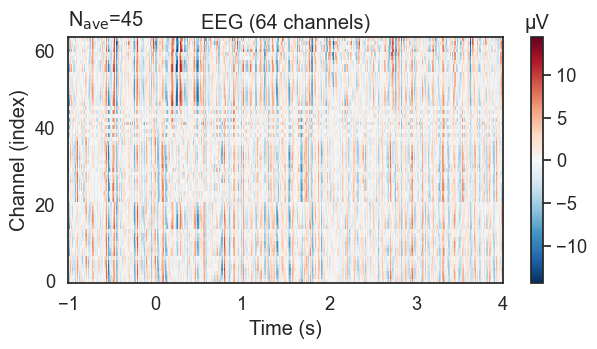

In [607]:
epochs.plot_psd();
epochs.average().plot_image();

In [608]:
psd_epoched, freqs = psd_array_welch(epochs_data, fmin=8.0, fmax=30.0, sfreq=160, n_fft=160)

psd_epoched.shape

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


(45, 64, 23)

# Welch PSD Validation

In [5]:
# Helpers 

def dom_frequency(coeff, frate=128):
    #dom frequency
      w = np.fft.fft(coeff)
      freqs = np.fft.fftfreq(len(w))
      # print(freqs.min(), freqs.max())

      # Find the peak in the coefficients
      idx = np.argmax(np.abs(w))
      freq = freqs[idx]
      return abs(freq * frate)
      # 439.8975

def flatten(l):
    for item in l:
        try:
            yield from flatten(item)
        except TypeError:
            yield item


def filtered(data):

    data = data.astype('float64')

    DataFilter.perform_bandpass(data, fs, 12.6491106, 36.0, 4,
                            FilterTypes.BESSEL.value, 0)
    DataFilter.remove_environmental_noise(data, fs, NoiseTypes.SIXTY.value)

    return data
  
def featurize(batches, level=4):
  # for electrode in range(batches.shape[1]-1):
  #   for coeff in (wavedec(filtered(batches[:, electrode]), 'db2', 'zero', level=level)):
  #     # print(coeff.shape)
  #     yield [dom_frequency(coeff), hjorth_params(coeff), num_zerocross(coeff), spectral_entropy(coeff, 128, nperseg=128), pd.Series(coeff).mad(), hurst_rs(coeff), app_entropy(coeff), lyap_r(coeff, emb_dim=2), svd_entropy(coeff), corr_dim(coeff, emb_dim=2), sample_entropy(coeff), np.amin(coeff), np.amax(coeff), np.mean([np.amin(coeff), np.amax(coeff)]), np.mean(np.square(coeff)), np.mean(coeff), np.var(coeff), np.std(coeff)]

  return [[[dom_frequency(coeff), hjorth_params(coeff), num_zerocross(coeff), spectral_entropy(coeff, 128, nperseg=128), pd.Series(coeff).mad(), hurst_rs(coeff), app_entropy(coeff), lyap_r(coeff, emb_dim=2), svd_entropy(coeff), corr_dim(coeff, emb_dim=2), sample_entropy(coeff), np.amin(coeff), np.amax(coeff), np.mean([np.amin(coeff), np.amax(coeff)]), np.mean(np.square(coeff)), np.mean(coeff), np.var(coeff), np.std(coeff)] for coeff in wavedec(filtered(batches[:, electrode]), 'db2', 'zero', level=level)] for electrode in range(batches.shape[1]-1)]
# dom frequency doesn't work, spectral_entropy has nan, 

def psd_mne(batches):
  info = mne.create_info(14, 128, ch_types='eeg')
  psd, freqs = mne.time_frequency.psd_welch(mne.io.RawArray(batches.T, info))

  freq_splits = [np.where(freqs < 4), np.where((freqs >= 8) & (freqs <= 12)), np.where((freqs >= 12) & (freqs < 16)), np.where((freqs >= 16) & (freqs < 25)), np.where((freqs >= 25) & (freqs < 39))]

  return np.array([[[np.mean(electrode[band])] for band in freq_splits] for electrode in tqdm(psd)]).reshape(14, 5)

def discrete_ft(x, sfreq, window=None):
    #initial variables
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N) # col vector
    k = n.reshape((N, 1)) # row vector 
    M = np.exp((-2j * np.pi * k * n)/ N) # dft matrix
    freq = n/(N/sfreq)

    if window:
      return np.dot(M, x*window), np.fft.fft(x*window), freq
    else:
      return np.dot(M, x), np.fft.fft(x), freq

In [6]:
epochs_train = epochs.copy() # full length 
epochs_data = epochs_train.get_data()

first_channel = epochs_data[0,0, :]
first_channel = first_channel.flatten()
len(first_channel)

801

Welch's periodogram algorithm based on: https://www.osti.gov/servlets/purl/5688766

In [7]:
# init params
N = len(first_channel) # length of the signal
fmin = 8
fmax = 30
fs = epochs.info['sfreq']
M = int((2/8)*fs) # window length long enough to cover at least 2 cycles of the lowest frequency of interest
# print(M)
S = M//2 # window step. 50% overlap is standard
seggs = []
K = (N-M)//S + 1 # number of segments

In [23]:
# Welch PSD 

for i in range(K):
    # print(i*S, i*S+M)
    seggs.append(first_channel[i*S:i*S+M])

w = np.hanning(M)
W = np.sum(w**2) # normalize the PSD
freqs = np.fft.fftfreq(M, 1/fs)
print(freqs)

psd_seggs = np.array([np.abs(np.fft.fft(seg*w))**2/W for seg in seggs])
print(psd_seggs.shape)
welch_psd = np.mean(psd_seggs, axis=0)
print(welch_psd.shape)

       

[  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76. -80. -76. -72. -68. -64. -60. -56. -52.
 -48. -44. -40. -36. -32. -28. -24. -20. -16. -12.  -8.  -4.]
(39, 40)
(40,)


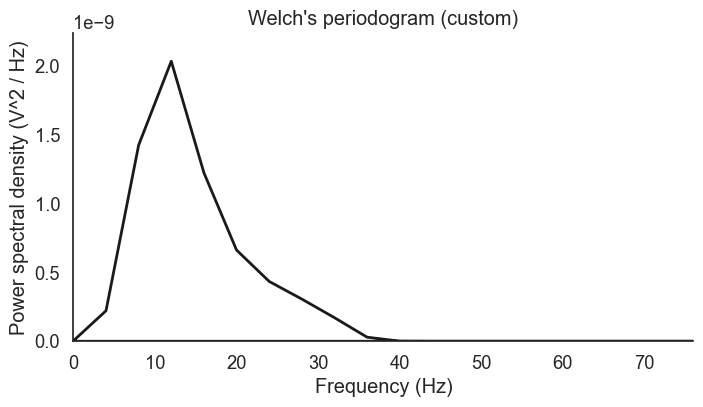

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, welch_psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, welch_psd.max() * 1.1])
plt.title("Welch's periodogram (custom)")
plt.xlim([0, freqs.max()])
sns.despine();
plt.show();

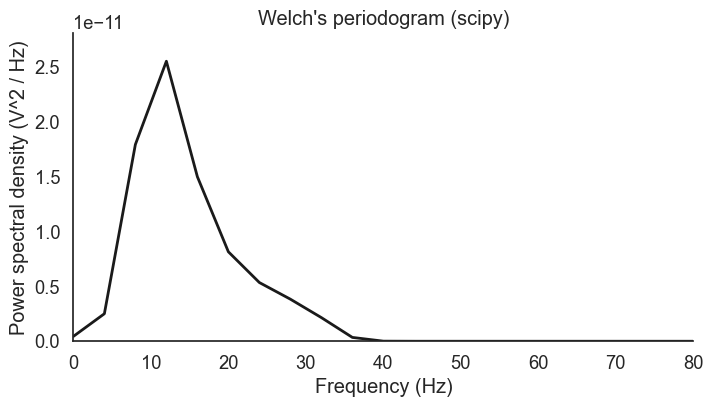

In [613]:
# test with scipy.signal.welch

from scipy import signal

# Define window length (4 seconds)
freqs, psd = signal.welch(first_channel, fs, nperseg=M, noverlap=S)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram (scipy)")
plt.xlim([0, freqs.max()])
sns.despine();
plt.show();

# Data Distribution Analysis

For CSP to be an appropriate method for this dataset, we need to test for multivariate normality. Essentially, all electrode data should follow a  joint gaussian distribution. 

In [44]:
epochs_data = epochs.get_data()
print(epochs_data.shape)

X = epochs_data[0, :, :].T
X.shape # (rows, cols)

(45, 64, 801)


(801, 64)

In [35]:
# univariate normality
from scipy.stats import normaltest

gaussian_elecs = {}

for i in range(X.shape[1]):
  stat, p = normaltest(X[:, i])
  if p > 0.05:
    gaussian_elecs[i] = ('Electrode %.2i, Statistics=%.3f, p=%.3f \n' % (i, stat, p))

print(len(gaussian_elecs))
for elec in gaussian_elecs:
  print(gaussian_elecs[elec])

# stat, p = normaltest(X[:, 0]) # first channel
# print('Statistics=%.3f, p=%.3f' % (stat, p))
# if p > 0.05:
#     print('Gaussian')


14
Electrode 03, Statistics=2.638, p=0.267 

Electrode 04, Statistics=1.439, p=0.487 

Electrode 05, Statistics=0.759, p=0.684 

Electrode 06, Statistics=1.581, p=0.454 

Electrode 11, Statistics=4.698, p=0.095 

Electrode 26, Statistics=1.589, p=0.452 

Electrode 31, Statistics=0.695, p=0.707 

Electrode 32, Statistics=2.184, p=0.336 

Electrode 33, Statistics=1.139, p=0.566 

Electrode 34, Statistics=0.463, p=0.793 

Electrode 35, Statistics=0.219, p=0.896 

Electrode 36, Statistics=2.054, p=0.358 

Electrode 39, Statistics=4.533, p=0.104 

Electrode 41, Statistics=3.141, p=0.208 



In [36]:
# mutlivariate normality test
import pingouin as pg
import numpy as np

normal_data = X[:, list(gaussian_elecs.keys())]
print(normal_data.shape)

# Compute the Henze-Zirkler test statistic and p-value
stat, pval, is_normal = pg.multivariate_normality(X, alpha=0.05)

# Print the results
print('Henze-Zirkler test statistic: %.2f' % stat)
print('p-value: %.4f' % pval)
print('Is the distribution normal? %s' % is_normal)


(801, 14)
Henze-Zirkler test statistic: 1.00
p-value: 0.0000
Is the distribution normal? False


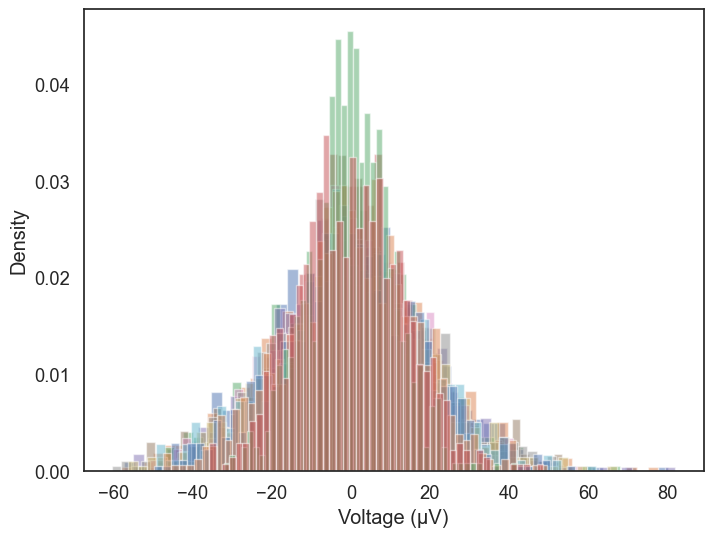

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Select the channels you want to analyze (e.g., channels 0, 1, and 2)
channels_data = X[:, list(gaussian_elecs.keys())]

# Set the scaling factor to convert from volts to microvolts
scaling_factor = 1e6

# Plot the voltage distribution PDF of all channels in a single plot
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(channels_data.shape[1]):
    ax.hist(channels_data[:, i]*scaling_factor, bins=50, density=True, alpha=0.5, label=f'Channel {i}')
    ax.set_xlabel('Voltage (μV)')
    ax.set_ylabel('Density')
if channels_data.shape[1] < 10:
    ax.legend()
plt.show()


In [29]:
# extract class labels
labels = epochs.events[:, -1] - 2
label_hands_idx = np.where(labels == 0)[0]
label_feet_idx = np.where(labels == 1)[0]

(45, 801)
(45, 801)
(2, 19224)
0.950527543997523


<Figure size 800x800 with 0 Axes>

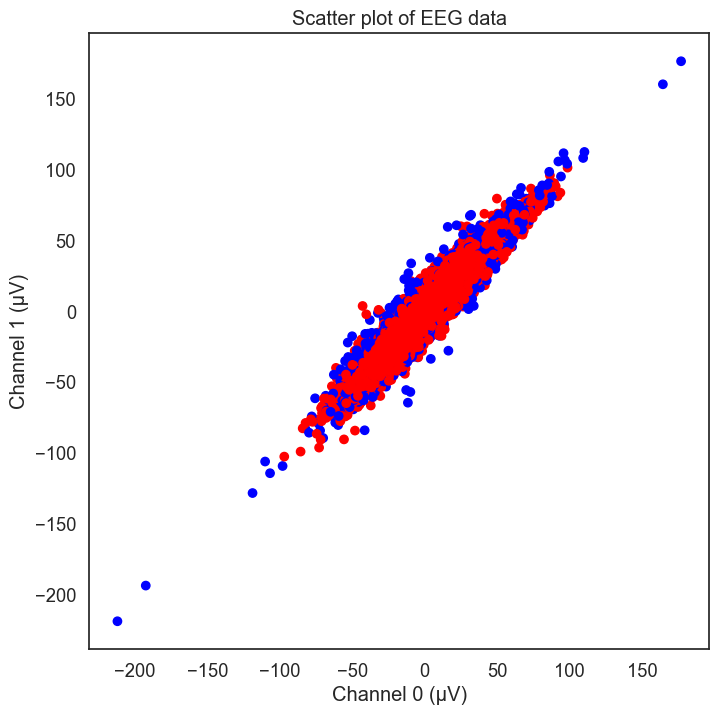

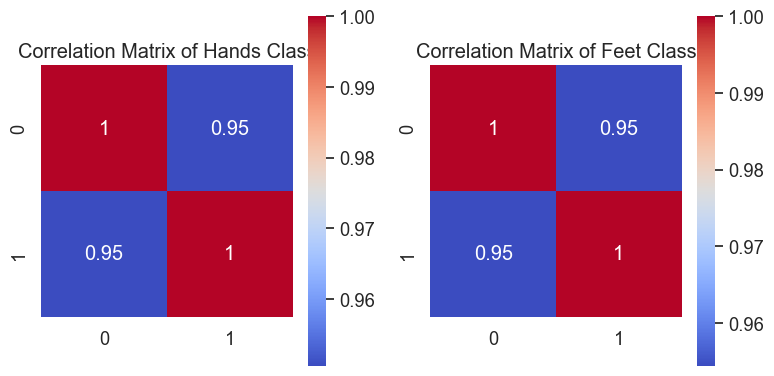

In [26]:
# scatter plot between channels and classes 
import seaborn as sns

# filter by class
ch_1 = epochs_data[:, 0, :]
ch_2 = epochs_data[:, 1, :]
labels = labels.reshape(-1, 1) * np.ones((1, ch_1.shape[1])) 

print(labels.shape)
print(ch_1.shape)

# Set the scaling factor to convert from volts to microvolts
scaling_factor = 1e6

# Create a scatter plot with color-coded points
plt.scatter(ch_1.flatten()*scaling_factor, ch_2.flatten()*scaling_factor, c=labels.flatten(), cmap='bwr')

# Add labels and a title
plt.xlabel('Channel 0 (μV)')
plt.ylabel('Channel 1 (μV)')
plt.title('Scatter plot of EEG data')

# inputs to cov and corr mats 
inp_hands = np.stack((ch_1[label_hands_idx, :].flatten(), ch_2[label_hands_idx, :].flatten()))
inp_feet = np.stack((ch_1[label_feet_idx, :].flatten(), ch_2[label_feet_idx, :].flatten()))
print(inp_feet.shape)

# Calculate cov matrix of two channels
cov_hands = np.cov(inp_hands)
cov_feet = np.cov(inp_feet)

# cov values are super small so convert to correlation between [-1, 1]
# cor_left = cov_left / np.sqrt(cov_left[0,0] * cov_left[1,1])
# print(cor_left)
cor_hands = np.corrcoef(inp_hands)
cor_feet = np.corrcoef(inp_feet)
print(cor_hands[0, 1])

# Plot the correlation matrices as heatmaps
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.heatmap(cor_hands, cmap='coolwarm', annot=True, square=True, ax=axs[0])
sns.heatmap(cor_feet, cmap='coolwarm', annot=True, square=True, ax=axs[1])
axs[0].set_title('Correlation Matrix of Hands Class')
axs[1].set_title('Correlation Matrix of Feet Class')
plt.tight_layout()

plt.show();


(64, 16821)
0.950527543997523


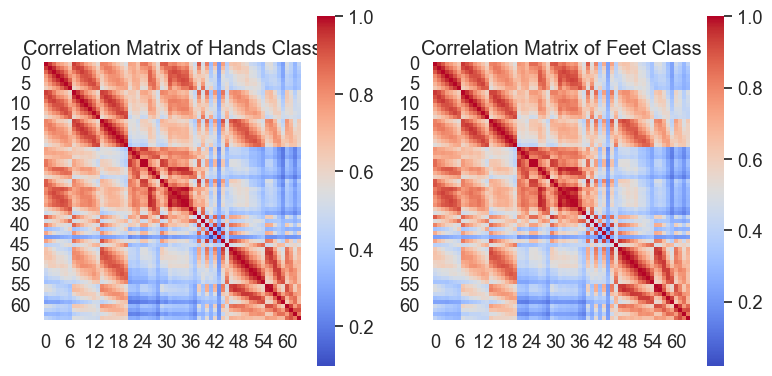

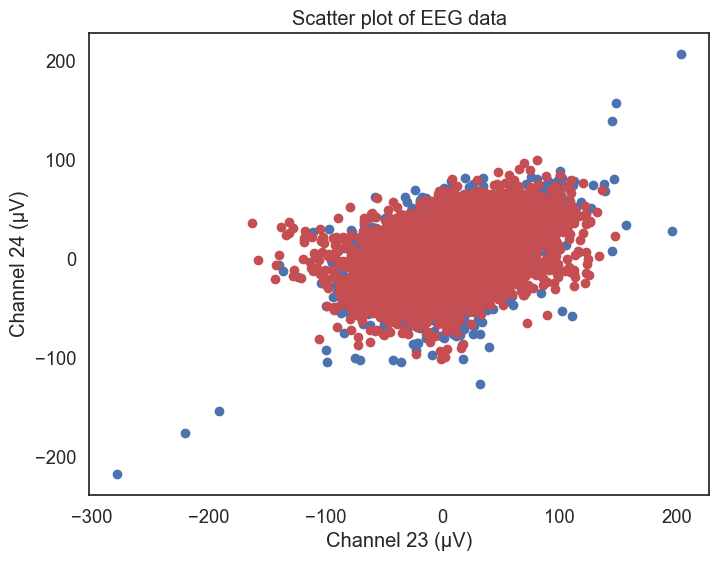

In [58]:
# 64 x 64 correlation matrix heatmap

# reshape epochs_data such that it is (64, n) where is n is flattened epochs
epoch_data_hands = epochs_data[label_hands_idx, :, :]
hands_flat = np.moveaxis(epoch_data_hands, 1, 0).reshape(64, -1)
epoch_data_feet = epochs_data[label_feet_idx, :, :]
feet_flat = np.moveaxis(epoch_data_feet, 1, 0).reshape(64, -1)
print(hands_flat.shape)

# calculate correlation matrix
cor_hands = np.corrcoef(hands_flat)
cor_feet = np.corrcoef(feet_flat)
print(cor_hands[0, 1])


# print(len(left_flat[0, :]))
# print(len(left_flat[1, :]))
# print(len(right_flat[0, :]))
# print(len(right_flat[1, :]))

# plot heatmap
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.heatmap(cor_hands, cmap='coolwarm', square=True, ax=axs[0])
sns.heatmap(cor_feet, cmap='coolwarm', square=True, ax=axs[1])
axs[0].set_title('Correlation Matrix of Hands Class')
axs[1].set_title('Correlation Matrix of Feet Class')
plt.tight_layout()

# view scatter plot of channel 1 and 2 for left and right classes on a new plot
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(hands_flat[60, :]*scaling_factor, hands_flat[25, :]*scaling_factor, c='b', label='hands')
plt.scatter(feet_flat[60, :]*scaling_factor, feet_flat[25, :]*scaling_factor, c='r', label='feet')

# Add labels and a title
plt.xlabel('Channel 23 (μV)')
plt.ylabel('Channel 24 (μV)')
plt.title('Scatter plot of EEG data')

plt.show();


In [41]:
# Find electrode pair with highest correlation in left class
max_cor = 0
max_cor_idx = 0
for i in range(32):
    for j in range(32):
        if i != j and cor_hands[i, j] > max_cor:
            max_cor = cor_hands[i, j]
            max_cor_idx = [i, j]

print(max_cor)
print(max_cor_idx)

# Find electrode pair with highest correlation in right class
max_cor = 0
max_cor_idx = 0
for i in range(32):
    for j in range(32):
        if i != j and cor_feet[i, j] > max_cor:
            max_cor = cor_feet[i, j]
            max_cor_idx = [i, j]

print(max_cor)
print(max_cor_idx)


0.9985860959049618
[24, 25]
0.998732620192489
[24, 25]


# Common Spatial Pattern Validation
https://mne.tools/stable/auto_examples/decoding/decoding_csp_eeg.html#ex-decoding-csp-eeg

In [8]:
# Reinitialize Vars for CSP

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


Classification with linear discriminant analysis

Computing rank from data with rank=None
    Using tolerance 9.2e-05 (2.2e-16 eps * 64 dim * 6.5e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8e-05 (2.2e-16 eps * 64 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e-05 (2.2e-16 eps * 64 dim * 6.4e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)


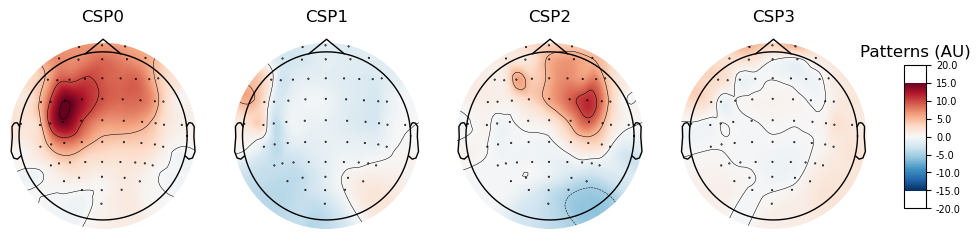

In [9]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
n_components = 4
csp = CSP(n_components=n_components, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5);

In [88]:
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

Classification accuracy: 0.944444 / Chance level: 0.533333


Performance over time

Computing rank from data with rank=None
    Using tolerance 9.2e-05 (2.2e-16 eps * 64 dim * 6.5e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8e-05 (2.2e-16 eps * 64 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e-05 (2.2e-16 eps * 64 dim * 6.4e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)


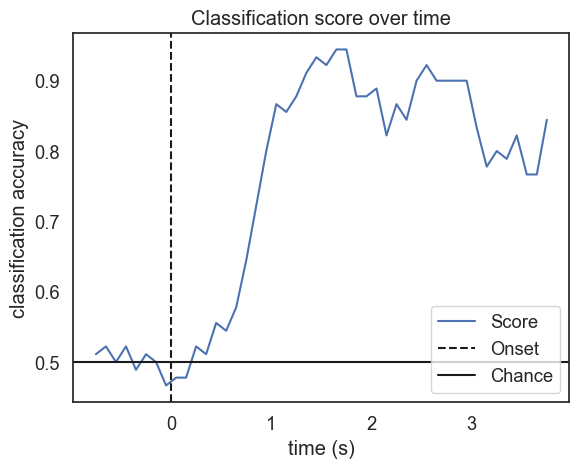

In [89]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        # print(epochs_data[test_idx][:, :, n:(n + w_length)].shape)
        # print(X_test.shape)
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

Validating CSP Filters

In [23]:
# CSP from scratch

import numpy as np
from scipy.linalg import eig

def gen_csp_filters(X_hands, X_feet, num_filters=64):
    # Compute the covariance matrices for each class
    cov_hands = np.cov(X_hands, bias=True) # normalized by N when bias=True
    cov_feet = np.cov(X_feet, bias=True)

    # Compute the generalized eigenvalue problem between the two covariance matrices
    # eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.inv(cov_hands + cov_feet), cov_hands))
    eigenvalues, eigenvectors = eig(cov_hands, cov_hands+cov_feet)

    # Sort the eigenvectors based on their eigenvalues
    # sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_indices = np.argsort(np.abs(eigenvalues - 0.5))[::-1] # sort by absolute deviation from 0.5 -> MNE implementation for 2-class csp
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    print('shape of eigenvectors', sorted_eigenvectors.shape)

    # Compute the CSP filters
    W = sorted_eigenvectors[:, :num_filters]

    # Return the CSP filters
    return W.T

def csp_explained_variance(X_left, X_right, csp_filters):
   # Calculate the covariance matrices for each class and the combined data
    cov_left = np.cov(X_left)
    cov_right = np.cov(X_right)
    cov_combined = cov_left + cov_right

    # Find the total variance in each class and across both classes
    total_var_left = np.sum(np.diag(cov_left))
    total_var_right = np.sum(np.diag(cov_right))
    total_var_combined = np.sum(np.diag(cov_combined))

    # Calculate the percentage of variance explained by each CSP component
    var_explained = []
    for i in range(num_components):
        # Calculate the covariance matrix for the i-th CSP component
        cov_i = np.cov(np.vstack((X_csp_left[:, i], X_csp_right[:, i])).T)
        # Find the variance explained in the left class by the i-th CSP component
        var_left_i = np.sum(np.diag(cov_i[:num_channels_csp, :num_channels_csp]))
        # Calculate the percentage of variance explained by the i-th CSP component
        var_explained_i = var_left_i / total_var_combined
        var_explained.append(var_explained_i)
    return explained_variance

def csp_forward_project(Z, csp_filters, verbose=False):
    csp_patterns = csp_filters.T
    if verbose:
        print('csp_patterns', csp_patterns.shape)
        print('Z', Z.shape)
    return np.dot(csp_patterns, Z)

# reset data vars
epoch_data_hands = epochs_data[label_hands_idx, :, :]
hands_flat = np.moveaxis(epoch_data_hands, 1, 0).reshape(64, -1)
epoch_data_feet = epochs_data[label_feet_idx, :, :]
feet_flat = np.moveaxis(epoch_data_feet, 1, 0).reshape(64, -1)

csp_filters = gen_csp_filters(hands_flat, feet_flat, 4)
print(csp_filters.shape)

csp_hands = np.dot(csp_filters, hands_flat)
forward_projected_hands = csp_forward_project(csp_hands, csp_filters)

print(csp_hands.shape)
print(forward_projected_hands.shape)

# explained_var = csp_explained_variance(hands_flat, feet_flat, csp_filters)
# print(explained_var)


shape of eigenvectors (64, 64)
(4, 64)
(4, 16821)
(64, 16821)


(64, 64)
(45, 64, 801)
(4, 801)


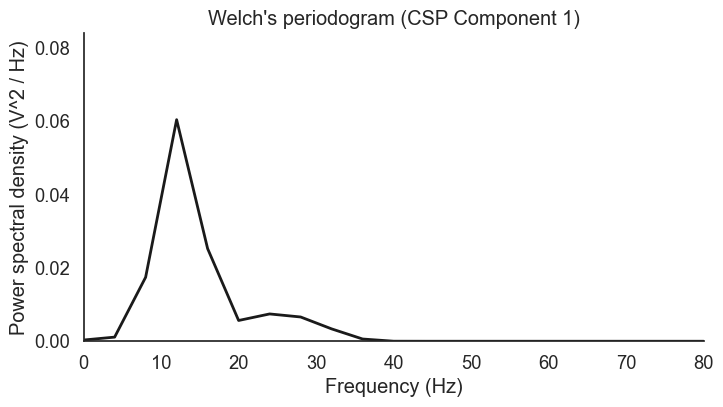

In [22]:
# Extract filters from CSP

csp_filters = csp.filters_
print(csp_filters.shape)

print(epochs_data.shape)
sample = epochs_data[0, :, :]

# Apply CSP filters to sample
components = csp_filters[:4, :] # each row vector filter is a "component"
csp_sample = np.dot(components, sample) # Linear transformation into CSP space
print(csp_sample.shape)

# test with psd

from scipy import signal

# Define window length (4 seconds)
freqs, psd = signal.welch(csp_sample, fs, nperseg=M, noverlap=S)

# Plot the power spectrum in CSP space
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd[0], color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram (CSP Component 1)")
plt.xlim([0, freqs.max()])
sns.despine();
plt.show();



(45, 4, 801)


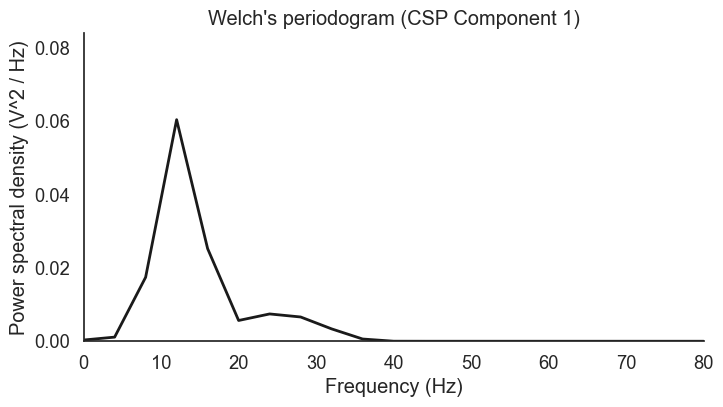

In [20]:
csp.set_params(transform_into='csp_space', log=None)
transform_epochs = csp.transform(epochs_data) # converts all epochs to CSP space

print(transform_epochs.shape)
transform_sample = transform_epochs[0, :, :]

# test with psd

from scipy import signal

# Define window length (4 seconds)
freqs, psd = signal.welch(transform_sample, fs, nperseg=M, noverlap=S)

# Plot the power spectrum in CSP space
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd[0], color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram (CSP Component 1)")
plt.xlim([0, freqs.max()])
sns.despine();
plt.show();

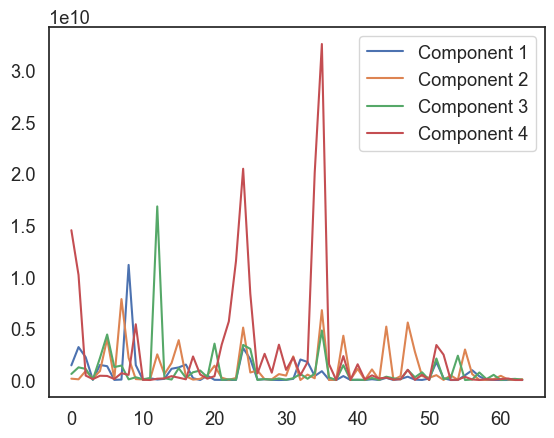

channels of importance in order [ 5 23  8 25  1  0 12 34 24 35]


In [17]:
# viewing channel importance from filter coefficient power

# Plot filter coefficients for each channel
fig, ax = plt.subplots()
for i, coef in enumerate(csp.filters_[:4, :]):
    ax.plot(abs(coef)**2, label=f'Component {i+1}')
ax.legend()
plt.show()

# find top 10 channels across first 4 components
top_channels = np.argsort(np.sum(abs(csp.filters_[:4, :])**2, axis=0))[-10:]
print('channels of importance in order', top_channels)

After applying the spatial transform, the distribution of data in each class should reflect some level of orthogonality. Scatter plot should show one class with minimal variance and the other with maximal variance.

(45, 64, 801)
(64, 36045)
(36045,)


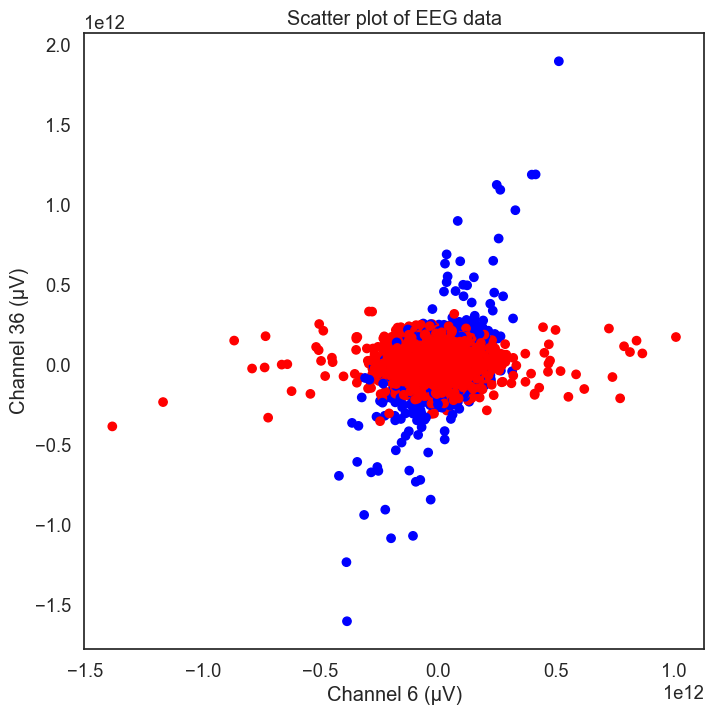

In [32]:
# reconstruct channel data from CSP space
components = csp.filters_[:n_components, :]
reconstructed_epochs = np.asarray([csp_forward_project(transform_epochs[i, :, :], components) for i in range(len(transform_epochs))])
print(reconstructed_epochs.shape)

hands_filtered = np.moveaxis(reconstructed_epochs[label_hands_idx, :, :], 1, 0).reshape(64, -1)
feet_filtered = np.moveaxis(reconstructed_epochs[label_feet_idx, :, :], 1, 0).reshape(64, -1)
# print(hands_filtered.shape)

trans_ep_flat = np.moveaxis(transform_epochs, 1, 0).reshape(n_components, -1)
rec_ep_flat = np.moveaxis(reconstructed_epochs, 1, 0).reshape(64, -1)
print(rec_ep_flat.shape)

labels_flat = (labels.reshape(-1, 1) * np.ones((1, reconstructed_epochs.shape[2]))).flatten() 
print(labels_flat.shape)

# scatter plot left and right classes after CSP filter

plt.figure(figsize=(8, 8))
# plt.scatter(hands_filtered[5, :1000]*scaling_factor, hands_filtered[35, :1000]*scaling_factor, c='b', label='hands')
# plt.scatter(feet_filtered[5, :1000]*scaling_factor, feet_filtered[35, :1000]*scaling_factor, c='r', label='feet')
plt.scatter(rec_ep_flat[5, :]*scaling_factor, rec_ep_flat[23, :]*scaling_factor, c=labels_flat[:], cmap='bwr')

# Add labels and a title
plt.xlabel('Channel 6 (μV)')
plt.ylabel('Channel 36 (μV)')
plt.title('Scatter plot of EEG data')

plt.show();



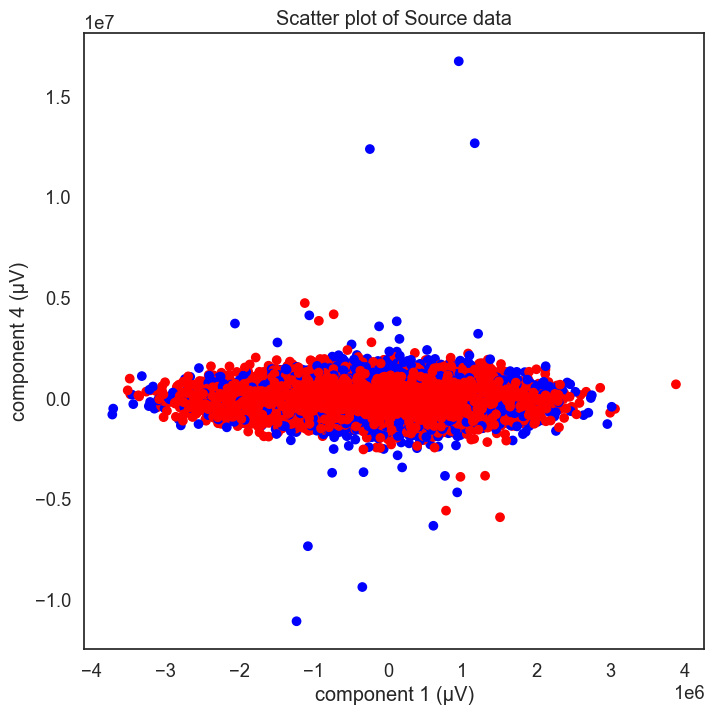

In [115]:
# scatter plot left and right classes in CSP space

plt.figure(figsize=(8, 8))
# plt.scatter(hands_filtered[5, :1000]*scaling_factor, hands_filtered[35, :1000]*scaling_factor, c='b', label='hands')
# plt.scatter(feet_filtered[5, :1000]*scaling_factor, feet_filtered[35, :1000]*scaling_factor, c='r', label='feet')
plt.scatter(trans_ep_flat[0, :]*scaling_factor, trans_ep_flat[3, :]*scaling_factor, c=labels_flat[:], cmap='bwr')

# Add labels and a title
plt.xlabel('component 1 (μV)')
plt.ylabel('component 4 (μV)')
plt.title('Scatter plot of Source data')

plt.show();

# Short Time Fourier Transform Spectrogram Validation

In [2]:
from scipy import signal

sample = reconstructed_epochs[0, 0, :]
print(sample.shape)

f, t, stft_arr = signal.stft(sample, fs, nperseg=M, noverlap=S)
print(t)

NameError: name 'reconstructed_epochs' is not defined

# Preprocessing Loop

1. Extract data from all subjects for hands vs. feet task
2. Bandpass filter 7-30hz
3. Fit and transform CSP
4. Transform to frequency domain using welch's periodogram or STFT